In [41]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#  Load and Clean Dataset

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [43]:
file_path = '/content/drive/MyDrive/AssignmentML/customer_churn.json'
mini_file_path = '/content/drive/MyDrive/AssignmentML/customer_churn_mini.json'

df1 = pd.read_json(file_path, lines=True)
df2 = pd.read_json(mini_file_path, lines=True)

df = pd.concat([df1, df2], ignore_index=True)

print(len(df))
df.head()


ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-1' coro=<Server.serve() done, defined at /usr/local/lib/python3.11/dist-packages/uvicorn/server.py:69> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/main.py", line 580, in run
    server.run()
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/server.py", line 67, in run
    return asyncio.run(self.serve(sockets=sockets))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 30, in run
    return loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 92, in run_until_complete
    self._run_once()
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 133, in _run_once
    handle._run()
  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run
    se

830205


,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
0,1538352011000,293,292,NextSong,Logged In,PUT,200,free,20,"Corpus Christi, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Morales,Joseph,1.532064e+12,M,Martin Orford,Grand Designs,597.55057
1,1538352025000,98,97,NextSong,Logged In,PUT,200,free,74,"Houston-The Woodlands-Sugar Land, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Larson,Sawyer,1.538070e+12,M,John Brown's Body,Bulls,380.21179
2,1538352118000,179,178,NextSong,Logged In,PUT,200,paid,184,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,1.535953e+12,M,Afroman,Because I Got High,202.37016
3,1538352119000,179,178,Logout,Logged In,PUT,307,paid,185,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,1.535953e+12,M,NaN,NaN,NaN
4,1538352124000,246,245,NextSong,Logged In,PUT,200,paid,22,"Mobile, AL",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Campos,Gianna,1.535931e+12,F,Lily Allen,Smile (Radio Edit),194.53342


Drop Rows with Missing Values

In [44]:
def check_missing_value(df):

    for col in df.columns:
        # Boolean mask for NaN or empty string
        missing = df[col].isna() | (df[col] == '')
        missing_count = missing.sum()
        if missing_count > 0:
            print(f"{col} = {missing_count}")

In [45]:
def remove_empty_column_values(df, x):
    """
    Remove rows where the specified column is NaN or an empty string (after stripping).

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        x (str): The column name to check for empty or NaN values.

    Returns:
        pd.DataFrame: A cleaned copy of the DataFrame.
    """
    return df[df[x].notna() & (df[x].astype(str).str.strip() != '')].copy()


Convert Timestamp from Epoch to Date Time

In [46]:
def add_subscription_days(df, ts_col='ts', registration_col='registration'):
    """
    Adds datetime columns and computes days of subscription based on epoch milliseconds.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        ts_col (str): Name of the timestamp column (in ms).
        registration_col (str): Name of the registration time column (in ms).

    Returns:
        pd.DataFrame: The DataFrame with added 'datetime', 'registration_datetime', and 'days_of_subscription' columns.
    """
    df = df.copy()
    df['datetime'] = pd.to_datetime(df[ts_col], unit='ms')
    df['registration_datetime'] = pd.to_datetime(df[registration_col], unit='ms')
    df['days_of_subscription'] = (df['datetime'] - df['registration_datetime']).dt.days
    return df


Extract Browser and Platform from UserAgent variable

In [47]:
# Function to extract browser
def get_browser(user_agent):
    if pd.isna(user_agent):
        return np.nan
    if "Firefox" in user_agent:
        return "Firefox"
    elif "Safari" in user_agent and "Chrome" in user_agent:
        return "Chrome"
    elif "Safari" in user_agent:
        return "Safari"
    elif "Trident" in user_agent:
        return "IE"
    else:
        return np.nan

# Function to extract platform
def get_platform(user_agent):
    if pd.isna(user_agent):
        return np.nan
    if "compatible" in user_agent or "Windows" in user_agent:
        return "Windows"
    elif "iPad" in user_agent:
        return "iPad"
    elif "iPhone" in user_agent:
        return "iPhone"
    elif "X11" in user_agent:
        return "Linux"
    elif "Macintosh" in user_agent:
        return "Mac"
    else:
        return np.nan

#

Extract state from location

In [48]:
def extract_state_from_location(df, location_col='location', new_col='state'):
    """
    Extracts the U.S. state abbreviation from the location column and adds it as a new column.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        location_col (str): The name of the column containing location strings.
        new_col (str): The name of the new column to store extracted state abbreviations.

    Returns:
        pd.DataFrame: The DataFrame with the added state abbreviation column.
    """
    df = df.copy()
    df[new_col] = df[location_col].str.extract(r',\s*([A-Z]{2})')
    return df


In [49]:
check_missing_value(df)


userId = 24046
location = 24046
userAgent = 24046
lastName = 24046
firstName = 24046
registration = 24046
gender = 24046
artist = 169220
song = 169220
length = 169220


In [50]:
def prepare_data(df):
    """
    Apply all prepare steps:
    1. Remove rows with empty or NaN 'userId'.
    2. Convert epoch timestamps to datetime and compute days of subscription.
    3. Extract browser and platform from 'userAgent'.
    4. Extract state abbreviation from 'location'.

    Parameters:
        df (pd.DataFrame): Raw input DataFrame.

    Returns:
        pd.DataFrame: Preprocessed DataFrame.
    """
    df = remove_empty_column_values(df, 'userId')
    df = add_subscription_days(df)

    # Extract browser and platform from userAgent
    df['browser'] = df['userAgent'].apply(get_browser)
    df['platform'] = df['userAgent'].apply(get_platform)

    df = extract_state_from_location(df)
    return df


In [51]:
df = prepare_data(df)
df.head().T

,0,1,2,3,4
ts,1538352011000,1538352025000,1538352118000,1538352119000,1538352124000
userId,293,98,179,179,246
sessionId,292,97,178,178,245
page,NextSong,NextSong,NextSong,Logout,NextSong
auth,Logged In,Logged In,Logged In,Logged In,Logged In
method,PUT,PUT,PUT,PUT,PUT
status,200,200,200,307,200
level,free,free,paid,paid,paid
itemInSession,20,74,184,185,22
location,"Corpus Christi, TX","Houston-The Woodlands-Sugar Land, TX","Orlando-Kissimmee-Sanford, FL","Orlando-Kissimmee-Sanford, FL","Mobile, AL"


Define Churn

In [52]:
# 1 = churned, 0 = not churned
df['churn_event'] = (df['page'] == 'Cancellation Confirmation').astype(int)


In [53]:
churn_counts = df[df['churn_event'] == 1].groupby('userId').size()
churn_counts

,0
userId,
10,1
100001,2
100003,2
100004,1
100005,2
...,...
81,1
85,1
87,1


# Exploratory Data Analysis

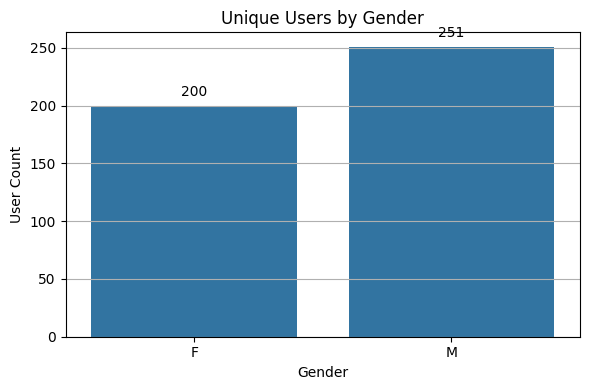

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by gender and count unique users
gender_count = df.groupby('gender')['userId'].nunique().reset_index()
gender_count.columns = ['gender', 'user_count']

# Set plot size
plt.figure(figsize=(6, 4))

# Create bar plot
ax = sns.barplot(x='gender', y='user_count', data=gender_count)

# Add data labels on bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Show plot
plt.title("Unique Users by Gender")
plt.ylabel("User Count")
plt.xlabel("Gender")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


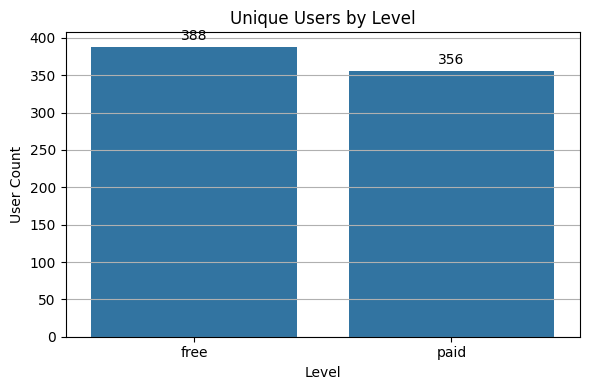

In [55]:
# 1. Group by level and count unique userIds
level_count = df.groupby('level')['userId'].nunique().reset_index()
level_count.columns = ['level', 'user_count']

# 2. Plot (small size)
plt.figure(figsize=(6, 4))
ax = sns.barplot(x='level', y='user_count', data=level_count)

# 3. Add data labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 8), textcoords='offset points')

# 4. Final touches
plt.title("Unique Users by Level")
plt.xlabel("Level")
plt.ylabel("User Count")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

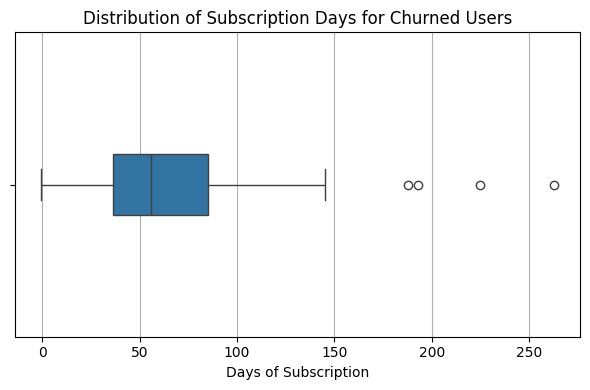

In [56]:
# Extract churned users
user_cancelled = df[df['page'] == 'Cancellation Confirmation'][['userId', 'auth', 'datetime', 'days_of_subscription']]
user_cancelled = user_cancelled.dropna(subset=['userId'])  # make sure to drop null userId if any


plt.figure(figsize=(6, 4))
sns.boxplot(x=user_cancelled['days_of_subscription'], width=0.2)
plt.xlabel('Days of Subscription')
plt.title('Distribution of Subscription Days for Churned Users')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()



the above fig tell us three things
- Most churned users canceled between 30–75 days.
- Median churn is around 50 days of usage.
- A few users churned very late (after 125+ days), but they are exceptions.

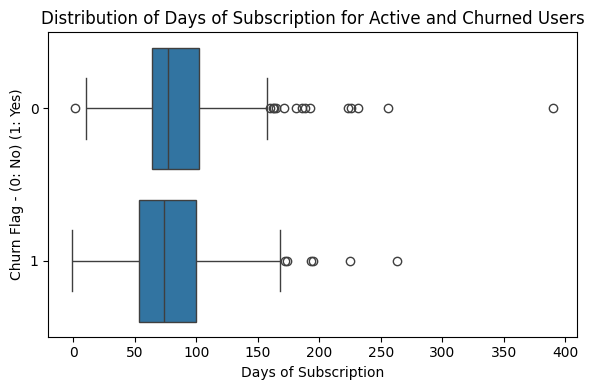

In [57]:
subscription_duration = df.groupby('userId').agg({
    'days_of_subscription': 'max',
    'churn_event': 'max'  # assuming this column is defined
}).reset_index()

# Plot
plt.figure(figsize=(6, 4))
sns.boxplot(x='days_of_subscription', y='churn_event', data=subscription_duration, orient='h')
plt.xlabel('Days of Subscription')
plt.ylabel('Churn Flag - (0: No) (1: Yes)')
plt.title('Distribution of Days of Subscription for Active and Churned Users')
plt.tight_layout()
plt.show()

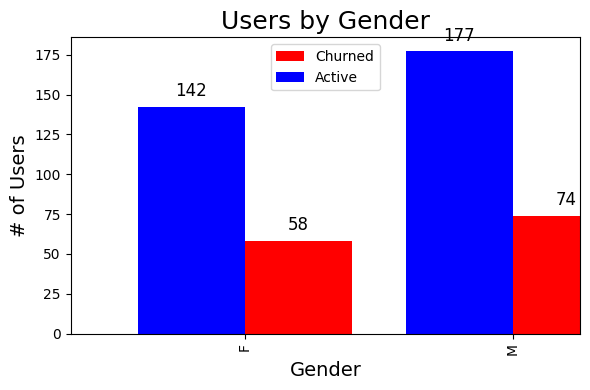

In [58]:
df['churn'] = df.groupby('userId')['churn_event'].transform('max')

#  Group by churn and gender, count unique users
gender_count = df.groupby(['churn', 'gender'])['userId'].nunique().reset_index()
gender_count.rename(columns={'userId': 'user_count'}, inplace=True)

# Pivot for plotting
unstacked_gender = gender_count.pivot(index='churn', columns='gender', values='user_count').fillna(0)

# Map churn 0/1 to descriptive labels
unstacked_gender.index = unstacked_gender.index.map({0: 'Active Users', 1: 'Churned Users'})

# Plot
plt.figure(figsize=(6, 4))
ax = unstacked_gender.loc['Churned Users'].plot(kind='bar', color='r', position=0, width=0.4, legend=True, label='Churned')
unstacked_gender.loc['Active Users'].plot(kind='bar', ax=ax, color='b', position=1, width=0.4, legend=True, label='Active')

# Labels and title
plt.title('Users by Gender', fontsize=18)
ax.set_xlabel("Gender", fontsize=14)
ax.set_ylabel("# of Users", fontsize=14)

# Add value labels to bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(str(int(height)),
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=12, xytext=(0, 5),
                    textcoords='offset points')

plt.tight_layout()
plt.show()


the above Fig show that females and males are equally likely to cancel service.


In [59]:
# Group by churn and calculate mean, max, and min for song length
length_stats = df.groupby('churn')['length'].agg(
    avg_length='mean',
    max_length='max',
    min_length='min'
).reset_index().sort_values('churn', ascending=False)

# Display the result
print(length_stats)


   churn  avg_length  max_length  min_length
1      1  248.874573  3024.66567     0.78322
0      0  248.793554  3024.66567     0.78322


In [60]:
# Group by churn status and user level, then count distinct users
level_churn_counts = df.drop_duplicates(subset=['userId', 'level']).groupby(['churn', 'level'])['userId'] \
                             .nunique().reset_index(name='user_count')

# Sort the result for display (like Spark SQL order)
level_churn_counts = level_churn_counts.sort_values(['churn', 'level'], ascending=[True, False])

# Show result
print(level_churn_counts)


   churn level  user_count
1      0  paid         248
0      0  free         273
3      1  paid         108
2      1  free         115


/tmp/ipython-input-61-1612409609.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='churn', y='artist_count', data=artist_count, palette='viridis')


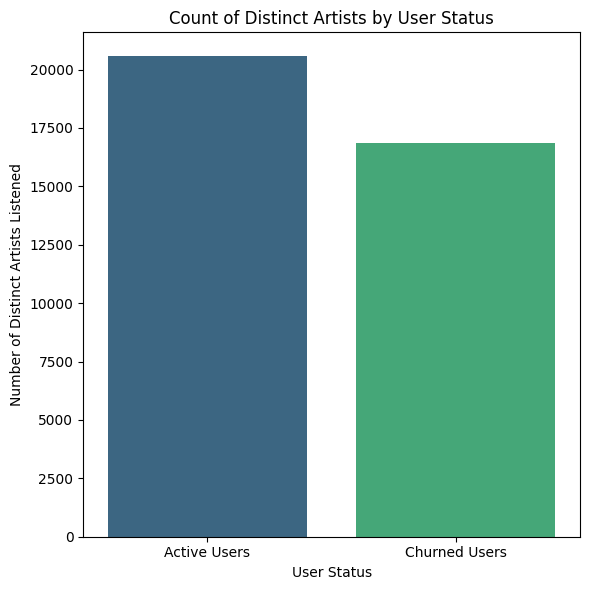

In [61]:
# Step 1: Count distinct artists per churn group
artist_count = df.groupby('churn')['artist'].nunique().reset_index(name='artist_count')

# Step 2: Map churn labels for readability
artist_count['churn'] = artist_count['churn'].map({0: 'Active Users', 1: 'Churned Users'})

# Step 3: Plot
plt.figure(figsize=(6, 6))
sns.barplot(x='churn', y='artist_count', data=artist_count, palette='viridis')
plt.xlabel('User Status')
plt.ylabel('Number of Distinct Artists Listened')
plt.title('Count of Distinct Artists by User Status')
plt.tight_layout()
plt.show()

From the above we can see Free and paid users are equally likely to cancel service

# Feature Engineering

In [62]:

df_features = (
    df.groupby('userId')
    .agg(
        label=('churn_event', 'max'),
        song_count=('page', lambda x: (x == 'NextSong').sum()),
        friend_count=('page', lambda x: (x == 'Add Friend').sum()),
        playlist_count=('page', lambda x: (x == 'Add to Playlist').sum()),
        thumbs_up_count=('page', lambda x: (x == 'Thumbs Up').sum()),
        thumbs_down_count=('page', lambda x: (x == 'Thumbs Down').sum()),
        # downgrade=('page', lambda x: (x == 'Downgrade').sum()),
        roll_advert=('page', lambda x: (x == 'Roll Advert').sum()),
        submit_downgrade=('page', lambda x: (x == 'Submit Downgrade').sum()),
        error_count=('page', lambda x: (x == 'Error').sum()),
        last_level_free=('level', lambda x: int(x.iloc[-1] == 'free')),
        last_level_paid=('level', lambda x: int(x.iloc[-1] == 'paid')),
        female_count=('gender', lambda x: int(x.iloc[0] == 'F')),
        male_count=('gender', lambda x: int(x.iloc[0] == 'M')),
        # phase=('downgraded', 'sum'),
        artist_count=('artist', lambda x: x.nunique()),
        windows_count=('platform', lambda x: (x == 'Windows').sum()),
        mac_count=('platform', lambda x: (x == 'Mac').sum()),
        mobile_count=('platform', lambda x: (x == 'iPhone').sum()),
        days_subscription=('days_of_subscription', 'max'),
        session_count=('sessionId', 'nunique'),
        usage_hours=('length', lambda x: x.dropna().sum() / (60 * 60))
    )
).reset_index()


In [63]:
df_features.head(3).T

,0,1,2
userId,10,100,100001
label,1,0,1
song_count,1033,6064,229
friend_count,15,120,3
playlist_count,23,155,6
thumbs_up_count,54,291,13
thumbs_down_count,5,64,3
roll_advert,1,33,27
submit_downgrade,0,1,0
error_count,1,6,1


In [64]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449 entries, 0 to 448
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   userId             449 non-null    object 
 1   label              449 non-null    int64  
 2   song_count         449 non-null    int64  
 3   friend_count       449 non-null    int64  
 4   playlist_count     449 non-null    int64  
 5   thumbs_up_count    449 non-null    int64  
 6   thumbs_down_count  449 non-null    int64  
 7   roll_advert        449 non-null    int64  
 8   submit_downgrade   449 non-null    int64  
 9   error_count        449 non-null    int64  
 10  last_level_free    449 non-null    int64  
 11  last_level_paid    449 non-null    int64  
 12  female_count       449 non-null    int64  
 13  male_count         449 non-null    int64  
 14  artist_count       449 non-null    int64  
 15  windows_count      449 non-null    int64  
 16  mac_count          449 non

# Model Building

In [65]:
from sklearn.model_selection import train_test_split

X = df_features.drop(['userId', 'label'], axis=1)
y = df_features['label']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

In [66]:
from sklearn.preprocessing import StandardScaler

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train the model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = lr.predict(X_test_scaled)

# Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[92  4]
 [29 10]]
              precision    recall  f1-score   support

           0       0.76      0.96      0.85        96
           1       0.71      0.26      0.38        39

    accuracy                           0.76       135
   macro avg       0.74      0.61      0.61       135
weighted avg       0.75      0.76      0.71       135



In [68]:
lr_balanced = LogisticRegression(class_weight='balanced', max_iter=1000)
lr_balanced.fit(X_train_scaled, y_train)
y_pred_bal = lr_balanced.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred_bal))
print(classification_report(y_test, y_pred_bal))

[[64 32]
 [17 22]]
              precision    recall  f1-score   support

           0       0.79      0.67      0.72        96
           1       0.41      0.56      0.47        39

    accuracy                           0.64       135
   macro avg       0.60      0.62      0.60       135
weighted avg       0.68      0.64      0.65       135



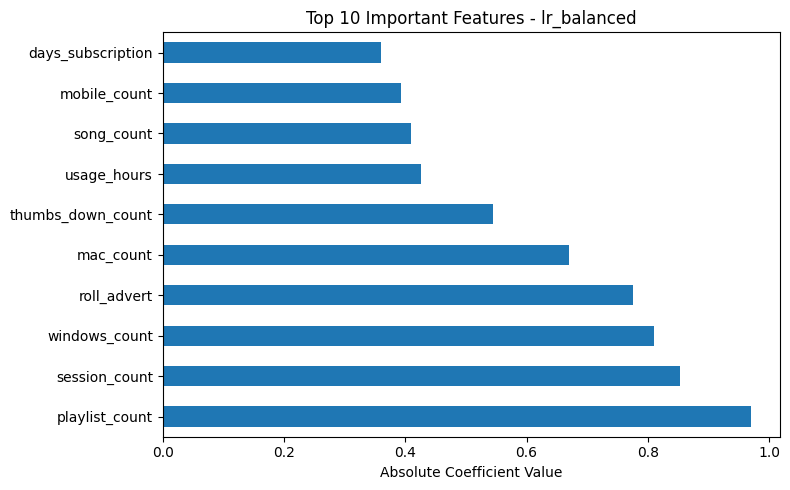

In [69]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot top features
# For Logistic Regression, use coef_ to get feature importance
# Taking the absolute value as larger magnitude indicates higher importance
feat_importance = pd.Series(abs(lr_balanced.coef_[0]), index=X.columns)
feat_importance.nlargest(10).plot(kind='barh', figsize=(8, 5))
plt.title("Top 10 Important Features - lr_balanced")
plt.xlabel("Absolute Coefficient Value")
plt.tight_layout()
plt.show()

In [71]:
import joblib

joblib.dump(lr_balanced, 'lrـmodel.pkl')


['lrـmodel.pkl']